In [2]:
# !pip install torch-fidelity
#  pip install torchmetrics scipy
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import zipfile
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical


In [6]:
# Function to unzip files
def unzip_files(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Unzipped {zip_path} to {extract_to}")

# Unzip the train and test files
unzip_files('/content/train.zip', '/content/train_data')
unzip_files('/content/test.zip', '/content/test_data')

Unzipped /content/train.zip to /content/train_data
Unzipped /content/test.zip to /content/test_data


In [8]:
train_df = pd.read_csv('/content/train_df.csv')
base_path = '/content/train_data/train'

# Add full path column
train_df['image_path'] = train_df.apply(
    lambda row: os.path.join(base_path, row['label'], f"{row['photo_id']}.jpg"),
    axis=1
)

# Preview the new column
print(train_df[['photo_id', 'label', 'image_path']].head())


                 photo_id label  \
0  DtyK_6rTTJuKDm0J-QQ7zw  food   
1  ZrCKGuVZFg91nrhK-HykxA  food   
2  Rr_tlQiAi1jta9Y0PHn3vA  food   
3  mUaVBiAH54HVJ2WeVe2eeA  food   
4  xbdqUD_ly1tgtp0TQSJE9Q  food   

                                          image_path  
0  /content/train_data/train/food/DtyK_6rTTJuKDm0...  
1  /content/train_data/train/food/ZrCKGuVZFg91nrh...  
2  /content/train_data/train/food/Rr_tlQiAi1jta9Y...  
3  /content/train_data/train/food/mUaVBiAH54HVJ2W...  
4  /content/train_data/train/food/xbdqUD_ly1tgtp0...  


In [9]:
train_df.tail()

,photo_id,business_id,caption,label,image_path
70988,r06A1rPKKrIX_5AYtZ0l4Q,8V9G6dC9sLCGp1LQVrmXwA,NaN,outside,/content/train_data/train/outside/r06A1rPKKrIX...
70989,CUV8RP4_Ta2NrpP6yP_RPA,3nXWsbhF0YkxUX9cUtqewg,Rose Tree Park -- Christmas lights 2018,outside,/content/train_data/train/outside/CUV8RP4_Ta2N...
70990,4FEYk2h1q_gNQw9o8LZN3Q,DeY0JL4MpfKfB4jf2Bx68w,NaN,outside,/content/train_data/train/outside/4FEYk2h1q_gN...
70991,STGJ7HR9U84MTW4g0ceASg,ac1AeYqs8Z4_e2X5M3if2A,Great restaurant!,outside,/content/train_data/train/outside/STGJ7HR9U84M...
70992,3KNxaeBtV2JfX3HJlyjqjA,1LGyVebO0VzuaMiFjpH3bg,NaN,outside,/content/train_data/train/outside/3KNxaeBtV2Jf...


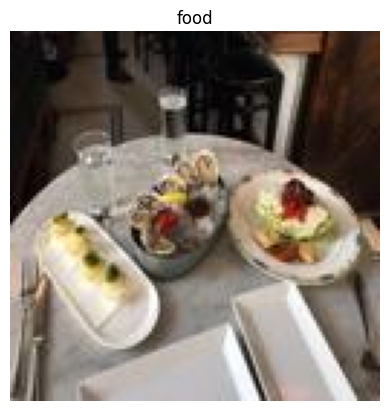

In [10]:
from PIL import Image
from matplotlib import pyplot as plt


sample_path = train_df['image_path'].iloc[0]
img = Image.open(sample_path)
plt.imshow(img)
plt.axis('off')
plt.title(train_df['label'].iloc[0])
plt.show()


In [11]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class YelpImageDataset(Dataset):
    def __init__(self, dataframe, image_size=128):
        self.df = dataframe
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),  # Converts to [0, 1]
            transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
        ])
        self.label_map = {'food': 0, 'drink': 1, 'inside': 2, 'outside': 3}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label_str = self.df.iloc[idx]['label']
        label = self.label_map[label_str]

        # Load and transform image
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        return img, label


In [12]:
from torch.utils.data import DataLoader

# Create dataset
train_dataset = YelpImageDataset(train_df)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)


Batch shape: torch.Size([64, 3, 128, 128]), Labels: [3, 2, 0, 2, 0, 3, 2, 1]


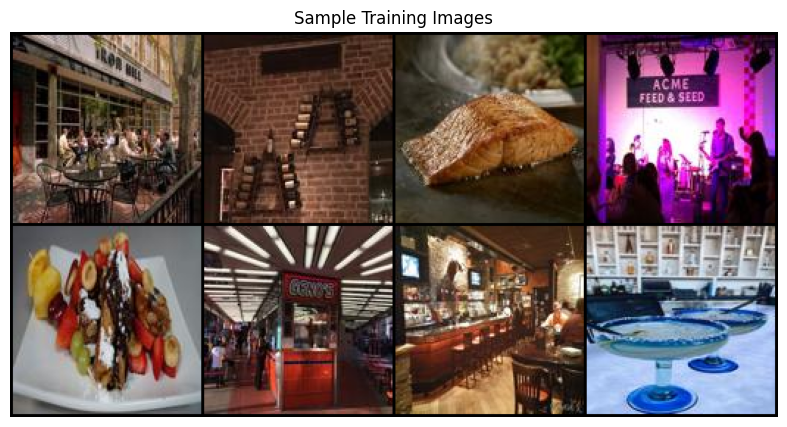

In [13]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels[:8].tolist()}")

# Show first 8 images
grid = vutils.make_grid(images[:8], nrow=4, normalize=True)
plt.figure(figsize=(10,5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Sample Training Images")
plt.show()


In [14]:
import torch.nn as nn
import torch

class Generator(nn.Module):
    def __init__(self, noise_dim=100, label_dim=4, img_channels=3, feature_dim=64):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)

        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, feature_dim * 8 * 4 * 4),
            nn.BatchNorm1d(feature_dim * 8 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (feature_dim * 8, 4, 4)),  # Shape: (B, 512, 4, 4)

            nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, 4, 2, 1),  # 8×8
            nn.BatchNorm2d(feature_dim * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, 4, 2, 1),  # 16×16
            nn.BatchNorm2d(feature_dim * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim * 2, feature_dim, 4, 2, 1),      # 32×32
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim, feature_dim // 2, 4, 2, 1),     # 64×64
            nn.BatchNorm2d(feature_dim // 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim // 2, img_channels, 4, 2, 1),    # 128×128
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embed = self.label_emb(labels)
        x = torch.cat([noise, label_embed], dim=1)
        return self.model(x)


In [15]:
class Discriminator(nn.Module):
    def __init__(self, label_dim=4, img_channels=3, feature_dim=64):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)

        self.model = nn.Sequential(

            nn.Conv2d(img_channels + 1, feature_dim // 2, 4, 2, 1),  # 64x64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim // 2, feature_dim, 4, 2, 1),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim, feature_dim * 2, 4, 2, 1),   # 16x16
            nn.BatchNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim * 2, feature_dim * 4, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim * 4, feature_dim * 8, 4, 2, 1),  # 4x4
            nn.BatchNorm2d(feature_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(feature_dim * 8 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, images, labels):
        label_embed = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_map = label_embed.expand(-1, -1, images.size(2), images.size(3))
        x = torch.cat([images, label_map[:, 0:1, :, :]], dim=1)
        return self.model(x)


**Initialize Models and Optimizers**

In [ ]:
noise_dim = 100
label_dim = 4
image_channels = 3
feature_dim = 64
lr = 2e-4
batch_size = 64

# Instantiate models
G = Generator(noise_dim, label_dim, image_channels, feature_dim).to(device)
D = Discriminator(label_dim, image_channels, feature_dim).to(device)

# Optimizers
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = torch.nn.BCELoss()


In [ ]:
import torch
import torchvision.utils as vutils
import os


epochs = 20
sample_interval = 10


os.makedirs('cgan_outputs', exist_ok=True)

# Label names
label_names = ['food', 'drink', 'inside', 'outside']


fixed_noise = torch.randn(4, noise_dim, device=device)
fixed_labels = torch.tensor([0, 1, 2, 3], device=device)

for epoch in range(1, epochs + 1):
    for i, (real_imgs, labels) in enumerate(train_loader):
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        # === Train Discriminator ===
        real_validity = D(real_imgs, labels)
        real_targets = torch.ones_like(real_validity, device=device)

        z = torch.randn(batch_size, noise_dim, device=device)
        fake_imgs = G(z, labels)
        fake_validity = D(fake_imgs.detach(), labels)
        fake_targets = torch.zeros_like(fake_validity, device=device)

        d_loss_real = criterion(real_validity, real_targets)
        d_loss_fake = criterion(fake_validity, fake_targets)
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        gen_validity = D(fake_imgs, labels)
        g_loss = criterion(gen_validity, real_targets)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    # Logging
    print(f"Epoch [{epoch}/{epochs}] | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

    # Save image samples every few epochs
    if epoch % sample_interval == 0 or epoch == epochs:
        G.eval()
        with torch.no_grad():
            fake_imgs = G(fixed_noise, fixed_labels)
            vutils.save_image(fake_imgs, f'cgan_outputs/epoch_{epoch}.png', nrow=4, normalize=True)
        G.train()


Epoch [1/20] | D_loss: 0.0480 | G_loss: 5.2023
Epoch [2/20] | D_loss: 0.6629 | G_loss: 1.8512
Epoch [3/20] | D_loss: 0.0667 | G_loss: 4.3477
Epoch [4/20] | D_loss: 0.0194 | G_loss: 5.3508
Epoch [5/20] | D_loss: 0.6881 | G_loss: 2.5747
Epoch [6/20] | D_loss: 0.5145 | G_loss: 10.6250
Epoch [7/20] | D_loss: 0.1475 | G_loss: 3.6639
Epoch [8/20] | D_loss: 0.0579 | G_loss: 3.9642
Epoch [9/20] | D_loss: 1.7745 | G_loss: 16.9301
Epoch [10/20] | D_loss: 0.0093 | G_loss: 6.0325
Epoch [11/20] | D_loss: 0.4268 | G_loss: 0.7834
Epoch [12/20] | D_loss: 0.4047 | G_loss: 5.6368
Epoch [13/20] | D_loss: 0.0292 | G_loss: 5.5243
Epoch [14/20] | D_loss: 0.0007 | G_loss: 8.5575
Epoch [15/20] | D_loss: 0.6992 | G_loss: 0.2265
Epoch [16/20] | D_loss: 0.5623 | G_loss: 0.9132
Epoch [17/20] | D_loss: 0.0908 | G_loss: 6.4391
Epoch [18/20] | D_loss: 0.2839 | G_loss: 7.5314
Epoch [19/20] | D_loss: 0.3286 | G_loss: 2.9744
Epoch [20/20] | D_loss: 0.1209 | G_loss: 3.8204


| Observation                                 | Interpretation                                              |
| ------------------------------------------- | ----------------------------------------------------------- |
| Fluctuating D_loss (0.0007 – 1.77)        | Discriminator is sometimes confident, sometimes confused    |
| G_loss varies a lot (0.2 – 16.9)          | Generator is sometimes fooling D, sometimes totally failing |
| Some very **low D\_loss + high G\_loss**    | D is overpowering G (G fails to fool D)                     |
| Some **very high G\_loss with low D\_loss** | G is learning aggressively or producing unrealistic samples |
| **No mode collapse** so far                 | Generator is producing varied outputs (good)                |


**saving model checkpoints**

In [ ]:
# torch.save(G.state_dict(), 'cgan_generator.pth')
# torch.save(D.state_dict(), 'cgan_discriminator.pth')


# Generating images

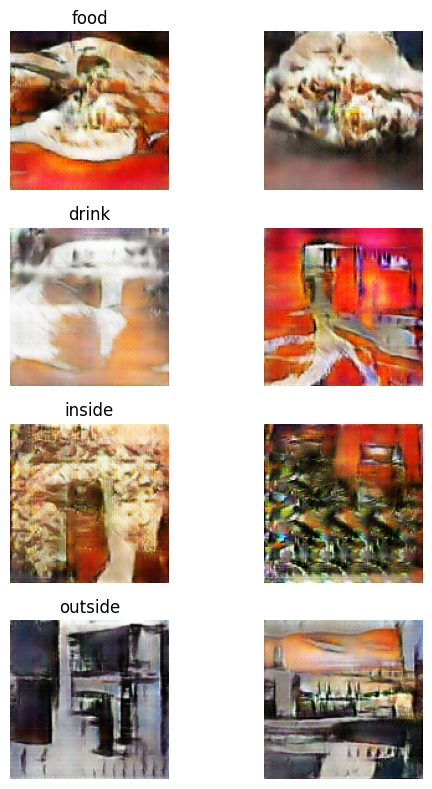

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

G.eval()
fig, axes = plt.subplots(len(label_names), 2, figsize=(6, 8))

with torch.no_grad():
    for row, label_id in enumerate(range(len(label_names))):
        for col in range(2):
            noise = torch.randn(1, noise_dim, device=device)
            label_tensor = torch.tensor([label_id], device=device)
            fake_img = G(noise, label_tensor)[0]  # shape: [3, H, W]

            # Convert tensor to PIL image for display
            img = TF.to_pil_image((fake_img + 1) / 2)  # unnormalize from [-1, 1] to [0, 1]

            axes[row, col].imshow(img)
            axes[row, col].axis('off')

            if col == 0:
                axes[row, col].set_title(label_names[label_id])

plt.tight_layout()
plt.show()



# Evaluation

Generating images labelwise

In [ ]:
import torch
import torchvision.utils as vutils
import os

# Define label names (you can modify these based on your labels)
label_names = ['food', 'drink', 'inside', 'outside']

# Set the generator to evaluation mode
G.eval()

# Make sure output directories exist
os.makedirs('cgan_outputs_final/per_label', exist_ok=True)

with torch.no_grad():
    for label_id, label_name in enumerate(label_names):
        label_dir = f'cgan_outputs_final/per_label/{label_name}'
        os.makedirs(label_dir, exist_ok=True)

        # Generate 100 images per label
        for i in range(100):  # 100 images per label
            noise = torch.randn(1, noise_dim, device=device)
            label_tensor = torch.tensor([label_id], device=device)

            fake_img = G(noise, label_tensor)

            # Save the generated image
            save_path = os.path.join(label_dir, f'{label_name}_{i + 1}.png')
            vutils.save_image(fake_img, save_path, normalize=True)

# Set the generator back to training mode if needed
G.train()


Generator(
  (label_emb): Embedding(4, 4)
  (model): Sequential(
    (0): Linear(in_features=104, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(512, 4, 4))
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))

In [ ]:
# import torch

# # Define the Generator and Discriminator classes (if not done already)

# # Initialize models
# G = Generator()  # Assuming your model architecture is defined
# D = Discriminator()

# # Load the saved model checkpoints
# G.load_state_dict(torch.load('cgan_generator.pth'))
# D.load_state_dict(torch.load('cgan_discriminator.pth'))

# # Set models to evaluation mode
# G.eval()
# D.eval()


In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
# Import FrechetInceptionDistance and InceptionScore explicitly
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to generated images
fake_dir = '/content/cgan_outputs_final/per_label'

# Path to real images (same label size and similar quantity)
real_dir = '/content/test_data/test'

# Transform to resize to 299x299 for InceptionV3
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

# Load real and fake image folders
real_dataset = ImageFolder(root=real_dir, transform=transform)
fake_dataset = ImageFolder(root=fake_dir, transform=transform)

real_loader = DataLoader(real_dataset, batch_size=16)
fake_loader = DataLoader(fake_dataset, batch_size=16)

# Calculate FID
fid = FrechetInceptionDistance(normalize=True).to(device)
for real, _ in real_loader:
    fid.update(real.to(device), real=True)
for fake, _ in fake_loader:
    fid.update(fake.to(device), real=False)

fid_score = fid.compute().item()

# Calculate Inception Score
# Concatenate all fake images into one tensor
all_fake_images = torch.cat([fake for fake, _ in fake_loader], dim=0).to(device)

# Convert the images to uint8 format (required by Inception Score)
all_fake_images = (all_fake_images * 255).clamp(0, 255).to(torch.uint8)

# Calculate Inception Score
inception = InceptionScore().to(device)
inception_score = inception(all_fake_images)[0].item()  # Get the mean score

print(f"FID Score: {fid_score:.4f}")
print(f"Inception Score: {inception_score:.4f}")


FID Score: 251.6553
Inception Score: 3.6319


Interpreting the Results:
FID Score: 251.65

The FID (Frechet Inception Distance) score compares the feature distributions of real and generated images.

Lower FID values indicate better performance: a value closer to 0 means the generated images are closer to real images in terms of feature space.

A high FID score (like 251.65) suggests that your generated images differ significantly from real images. This could indicate that the model is not generating realistic images, or the features extracted by InceptionV3 are not matching well between real and generated images.

Inception Score: 3.63

The Inception Score (IS) measures both quality and diversity of the generated images.

Higher IS values are better, and typically values between 5 and 10 are considered good for high-quality generative models.

An IS of 1.3037 is very low, suggesting that the generated images either lack quality or diversity. Your model might be generating images that are either hard to classify or are too similar to each other.

In [ ]:
# !zip -r cgan_outputs.zip cgan_outputs_final/

# Model Tuning1

| **Feature**                 | **Old Model**                   | **New Model**                                                                       | **Reason for Change (Based on Old Model's Observations)**                                                                                                                                                                                                                                                                                                            |
| --------------------------- | ------------------------------- | ----------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Loss Function**           | `nn.Sigmoid()` + `nn.BCELoss()` | `nn.BCEWithLogitsLoss()`                                                            | **Issue**: The old model's loss fluctuations indicated instability. **BCEWithLogitsLoss** is more **numerically stable** and helps with vanishing gradients, improving training stability and reducing fluctuations in loss values, which was seen in the old model.                                                                                                 |
| **Label Smoothing**         | Not used                        | `real_targets = torch.full_like(real_validity, 0.9)`                                | **Issue**: The discriminator became overly confident, causing poor generalization and mode collapse (seen in high variance of `G_loss`). Label smoothing prevents overconfidence, encouraging the discriminator to be less strict and improving GAN stability.                                                                                                       |
| **Learning Rate Scheduler** | Not used                        | `ReduceLROnPlateau` (for both generator and discriminator)                          | **Issue**: The old model showed large swings in `G_loss` and `D_loss`, suggesting that the learning rate may not have been adapting well to the training progress. The learning rate scheduler reduces the learning rate when the loss plateaus, helping the model converge more smoothly and avoiding overshooting in future iterations.                            |
                                                                                                            |
| **Epochs**                  | 20 epochs                       | 50 epochs                                                                           | **Issue**: With only 20 epochs, the model did not have enough time to improve, as seen in the fluctuating losses and the performance metrics. **GANs often require longer training** to generate high-quality outputs. The new model is trained for 50 epochs to allow more time for improvements and convergence.                                                                                                          
| **Evaluation Interval**     | Not specified                   | Evaluates FID and IS **every 10 epochs**                                            | **Issue**: Without intermediate evaluations, it was difficult to track progress during training. Evaluating every 10 epochs allows for monitoring improvements in **image quality** and metrics over time, helping identify when the model is improving and when adjustments are needed.                                                                             |


In [16]:
# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim=100, label_dim=4, img_channels=3, feature_dim=64):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, feature_dim * 8 * 4 * 4),
            nn.BatchNorm1d(feature_dim * 8 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (feature_dim * 8, 4, 4)),

            nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_dim * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_dim * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim * 2, feature_dim, 4, 2, 1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim, feature_dim // 2, 4, 2, 1),
            nn.BatchNorm2d(feature_dim // 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_dim // 2, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embed = self.label_emb(labels)
        x = torch.cat([noise, label_embed], dim=1)
        return self.model(x)

In [17]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, label_dim=4, img_channels=3, feature_dim=64):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Conv2d(img_channels + 1, feature_dim // 2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim // 2, feature_dim, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim, feature_dim * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim * 2, feature_dim * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_dim * 4, feature_dim * 8, 4, 2, 1),
            nn.BatchNorm2d(feature_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(feature_dim * 8 * 4 * 4, 1)
        )

    def forward(self, images, labels):
        label_embed = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_map = label_embed.expand(-1, -1, images.size(2), images.size(3))
        x = torch.cat([images, label_map[:, 0:1, :, :]], dim=1)
        return self.model(x)

In [18]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=8, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [20]:
import torch
import torchvision.utils as vutils
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Initialize everything
noise_dim = 100
label_dim = 4
image_channels = 3
feature_dim = 64
lr = 2e-4
batch_size = 64
epochs = 50
sample_interval = 10

label_names = ['food', 'drink', 'inside', 'outside']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator(noise_dim, label_dim, image_channels, feature_dim).to(device)
D = Discriminator(label_dim, image_channels, feature_dim).to(device)

criterion = nn.BCEWithLogitsLoss()

g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

g_scheduler = ReduceLROnPlateau(g_optimizer, mode='min', factor=0.5, patience=4, verbose=True)
d_scheduler = ReduceLROnPlateau(d_optimizer, mode='min', factor=0.5, patience=4, verbose=True)

os.makedirs('cgan_outputs', exist_ok=True)
fixed_noise = torch.randn(4, noise_dim, device=device)
fixed_labels = torch.tensor([0, 1, 2, 3], device=device)

early_stopper = EarlyStopping(patience=8)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# === Training Loop ===
for epoch in range(1, epochs + 1):
    for i, (real_imgs, labels) in enumerate(train_loader):
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        # Label smoothing
        real_targets = torch.full((batch_size, 1), 0.9, device=device)
        fake_targets = torch.zeros((batch_size, 1), device=device)

        # === Train Discriminator ===
        real_validity = D(real_imgs, labels)
        d_loss_real = criterion(real_validity, real_targets)

        z = torch.randn(batch_size, noise_dim, device=device)
        fake_imgs = G(z, labels)
        fake_validity = D(fake_imgs.detach(), labels)
        d_loss_fake = criterion(fake_validity, fake_targets)

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        gen_validity = D(fake_imgs, labels)
        g_loss = criterion(gen_validity, real_targets)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch}/{epochs}] | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

    g_scheduler.step(g_loss.item())
    d_scheduler.step(d_loss.item())

    # Save samples
    if epoch % sample_interval == 0 or epoch == epochs:
        G.eval()
        with torch.no_grad():
            sample_imgs = G(fixed_noise, fixed_labels)
            vutils.save_image(sample_imgs, f'cgan_outputs/epoch_{epoch}.png', nrow=4, normalize=True)
        G.train()

    # Early stopping
    early_stopper(g_loss.item())
    if early_stopper.early_stop:
        print(f"\nEarly stopping triggered at epoch {epoch}")
        break

Epoch [1/50] | D_loss: 0.9263 | G_loss: 2.9570
Epoch [2/50] | D_loss: 0.4920 | G_loss: 3.6316
Epoch [3/50] | D_loss: 0.6177 | G_loss: 3.1576
Epoch [4/50] | D_loss: 2.9779 | G_loss: 2.4796
Epoch [5/50] | D_loss: 0.3814 | G_loss: 3.7697
Epoch [6/50] | D_loss: 0.3893 | G_loss: 5.1004
Epoch [7/50] | D_loss: 0.4600 | G_loss: 2.9648
Epoch [8/50] | D_loss: 0.4507 | G_loss: 2.9763
Epoch [9/50] | D_loss: 0.4014 | G_loss: 4.8763
Epoch [10/50] | D_loss: 0.4728 | G_loss: 3.1378
Epoch [11/50] | D_loss: 0.3678 | G_loss: 4.8473
Epoch [12/50] | D_loss: 0.8184 | G_loss: 1.3089
Epoch [13/50] | D_loss: 0.5826 | G_loss: 2.3414
Epoch [14/50] | D_loss: 1.1330 | G_loss: 7.4948
Epoch [15/50] | D_loss: 0.4012 | G_loss: 3.7123
